<center> Advanced Integration and Annotation of scRNA-seq Data Using scVI: Hyperparameter Tuning, Label Transfer, and Custom Reference Creation

# Introduction

In this notebook, data from 10X Genomics will be uploaded following the application of Harmony correction. The scVI model, a preferred integration method for scRNA-seq data, will be tested here. Additionally, scVI and scANVI will be applied to enable label transfer from the CZI scRNA-seq atlas, which contains six RNA-seq samples.

The procedure is divided into two parts. First, label transfer and the second will be integration.

First, the data will be uploaded. For those interested in exploring alternative label transfer methods, the `celltypist` model can be used. However, this notebook will focus on atlas-based label transfer. [GitHub reference](https://github.com/mousepixels/sanbomics_scripts/blob/main/sc2024/annotation_integration.ipynb)


### Label Transfer

In [1]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [2]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scvi
import torch
import celltypist
from celltypist import models
from scvi.autotune import ModelTuner
from ray import tune
import ray

In [3]:
print("CUDA available:", torch.cuda.is_available())

CUDA available: True


In [4]:
pathout = "/data/kanferg/Sptial_Omics/SpatialOmicsToolkit/out_4"

#### Reference from CZI:

In [5]:
ref_name = "/data/kanferg/Sptial_Omics/playGround/Data/Breast_Cancer/ref/breast_cancer_sc_czi.h5ad"
adata_ref_init = sc.read_h5ad(ref_name)
# select all the breast samples
adata_ref_tisueRM = adata_ref_init[adata_ref_init.obs['tissue']=='breast',:].copy()
# select all the protein_coding
adata_ref = adata_ref_tisueRM[:,adata_ref_tisueRM.var['feature_type']=='protein_coding'].copy()
adata_ref.var.index = adata_ref.var["feature_name"].astype(str).values
adata_ref

AnnData object with n_obs × n_vars = 34164 × 18626
    obs: 'condition', 'replicate', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'RNA_snn_res.0.8', 'seurat_clusters', 'labels_score', 'Order', 'Lane', 'Index', 'cancer', 'reference', 'flowcell', 'min_umis', 'min_genes', 'percent_mito', 'expected_cells', 'total_droplets', 'z_dim', 'z_layers', 'channel_id', 'labels_cl_unif_per_channel', 'filt_median_genes', 'filt_median_umi', 'pass', 'ccpm_id', 'htapp', 'sequenced', 'stage_at_diagnosis', 'metastatic_presentation', 'biopsy_days_after_metastasis', 'ER_primary', 'ER_biopsy', 'PR_primary', 'PR_biopsy', 'HER2_primary', 'HER2_biopsy', 'receptors_primary', 'receptors_biopsy', 'site_biopsy', 'histology_breast', 'histology_biopsy', 'sampleid', 'cnv_cors', 'cnv_cors_max', 'cnv_score', 'cnv_ref_score', 'cnv_score_norm', 'cnv_score_norm_norm', 'cnv_condition', 'cnv_score_norm_norm2', 'pam50_Basal_single', 'pam50_Her2_single', 'pam50_LumA_single', 'pam50_LumB_single', 'pam50_Normal_single', 'pam50_m

In [6]:
from anndata import AnnData
rdata = AnnData(adata_ref.X, obs={"CellType": adata_ref.obs["cell_type"].values,"nCount_RNA":adata_ref.obs["nCount_RNA"].values,'percent_mito':adata_ref.obs["percent_mito"]} , var ={"n_cells":adata_ref.var["n_cells"].values, "feature_name":adata_ref.var["feature_name"].astype(str).values} )
rdata.var.index = rdata.var["feature_name"].values
rdata

AnnData object with n_obs × n_vars = 34164 × 18626
    obs: 'CellType', 'nCount_RNA', 'percent_mito'
    var: 'n_cells', 'feature_name'

In [7]:
rdata.obs.groupby('CellType').size()

CellType
fibroblast                               2797
blood vessel endothelial cell            2816
T cell                                   1274
adipocyte                                 595
chondrocyte                                 1
macrophage                                639
plasma cell                                31
mature NK T cell                           25
malignant cell                          25685
blood vessel smooth muscle cell           300
endothelial cell of hepatic sinusoid        1
dtype: int64

In [8]:
remove_cell = ['endothelial cell of hepatic sinusoid','chondrocyte']
rdata = rdata[~rdata.obs['CellType'].isin(remove_cell), :]
rdata.obs.groupby('CellType').size()

CellType
fibroblast                          2797
blood vessel endothelial cell       2816
T cell                              1274
adipocyte                            595
macrophage                           639
plasma cell                           31
mature NK T cell                      25
malignant cell                     25685
blood vessel smooth muscle cell      300
dtype: int64

In [9]:
rdata = rdata[~rdata.obs.CellType.isna()]

In [10]:
# needs row count data and celltype in ref dataset and query data set. also batch
rdata.obs['batch'] = 'ref'
rdata.obs['sample'] = 'refrance'


After preparing the reference data for label transfer, make sure to add batch and sample keys for the breast cancer data. These keys should include relevant batch and sample identifiers. Additionally, a CellType key should be added and labeled as ‘Unknown’. This column will be used to identify cell types based on the reference data.

> **Note:** For scVI, use raw (unnormalized) and unlogged counts.


In [11]:
pathout = "/data/kanferg/Sptial_Omics/SpatialOmicsToolkit/out_4"
bcdata_init = sc.read_h5ad(os.path.join(pathout, "adata_concat_BreastCancer_harmony.h5ad"))
bcdata_init.X = bcdata_init.layers['counts']

In [12]:
# Rename mitochodria percent will be usfull for integration
bcdata_init.obs['percent_mito'] = bcdata_init.obs['pct_counts_MT'].values
bcdata_init.obs['CellType'] = 'Unknown'
bcdata_init.obs['sample'] = 'ST'

andata_combined = sc.concat((bcdata_init,rdata))

In [13]:
scvi.model.SCVI.setup_anndata(andata_combined, batch_key='batch', categorical_covariate_keys = ['sample'])
model_scvi = scvi.model.SCVI(andata_combined)
max_epochs_scvi = np.min([round((20000 / andata_combined.n_obs) * 100), 100])
model_scvi.train(max_epochs=27)

Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA
Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Epoch 27/27: 100%|██████████| 27/27 [10:44<00:00, 23.79s/it, v_num=1, train_loss_step=203, train_loss_epoch=167]

`Trainer.fit` stopped: `max_epochs=27` reached.


Epoch 27/27: 100%|██████████| 27/27 [10:44<00:00, 23.89s/it, v_num=1, train_loss_step=203, train_loss_epoch=167]


In [14]:
model_scANvi = scvi.model.SCANVI.from_scvi_model(model_scvi, adata = andata_combined, unlabeled_category = 'Unknown',labels_key = 'CellType')
max_epochs_scanvi = int(np.min([10, np.max([2, round(max_epochs_scvi / 3.0)])]))
#model_scANvi.train(max_epochs=max_epochs_scanvi, n_samples_per_label=100)
model_scANvi.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Epoch 20/20: 100%|██████████| 20/20 [16:02<00:00, 48.14s/it, v_num=1, train_loss_step=155, train_loss_epoch=156]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [16:02<00:00, 48.14s/it, v_num=1, train_loss_step=155, train_loss_epoch=156]


In [15]:
andata_combined.obs['predicted'] = model_scANvi.predict(andata_combined)
andata_combined.obs['transfer_score'] = model_scANvi.predict(soft = True).max(axis = 1)
andata_save = andata_combined.copy()
#andata_save.write_h5ad(os.path.join(pathout, "adata_concat_BreastCancer_harmony_scVI_scANVI_unintigrated.h5ad"))

In [16]:
andata_combined

AnnData object with n_obs × n_vars = 328122 × 1066
    obs: 'batch', 'percent_mito', 'CellType', 'sample', '_scvi_batch', '_scvi_labels', 'predicted', 'transfer_score'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: '_scvi_extra_categorical_covs'

# Integration

In this step, we will perform batch integration. It is essential to fine-tune the network for optimal predictions. The goal is to predict the latent space (hidden layer) of the network, and then perform K-Nearest Neighbors (KNN) and Leiden clustering on this layer.


In [3]:
# remove the refferance data
# andata_bc = andata_combined[andata_combined.obs['sample']=='ST'].copy()
pathout = "/data/kanferg/Sptial_Omics/SpatialOmicsToolkit/out_4"
andata_combined = sc.read_h5ad(os.path.join(pathout, "adata_concat_BreastCancer_harmony_scVI_scANVI_unintigrated.h5ad"))
andata_bc = andata_combined[andata_combined.obs['sample']=='ST'].copy()

In [4]:
model_cls = scvi.model.SCVI
model_cls.setup_anndata(andata_bc, categorical_covariate_keys = ['batch'],
                             continuous_covariate_keys=['percent_mito'])
tuner = ModelTuner(model_cls)

Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA
Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


In [5]:
tuner.info()

ModelTuner registry for SCVI

                  Tunable hyperparameters                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃      Hyperparameter      ┃ Default value ┃    Source    ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│         n_hidden         │      128      │     VAE      │
│         n_latent         │      10       │     VAE      │
│         n_layers         │       1       │     VAE      │
│       dropout_rate       │      0.1      │     VAE      │
│        dispersion        │     gene      │     VAE      │
│     log_variational      │     True      │     VAE      │
│     gene_likelihood      │     zinb      │     VAE      │
│   latent_distribution    │    normal     │     VAE      │
│    encode_covariates     │     False     │     VAE      │
│ deeply_inject_covariates │     True      │     VAE      │
│      use_batch_norm      │     both      │     VAE      │
│      use_layer_norm      │     none      │     VAE      │
│  use_observed_lib_size   │     True      │     VAE      │
│      var_activation      │     None      │     VAE      │
│        optimizer         │     Adam      │ TrainingPlan │
│            lr            │     0.001     │ TrainingPlan │
│       weight_decay       │     1e-06     │ TrainingPlan │
│           eps            │     0.01      │ TrainingPlan │
│    n_steps_kl_warmup     │     None      │ TrainingPlan │
│    n_epochs_kl_warmup    │      400      │ TrainingPlan │
│   reduce_lr_on_plateau   │     False     │ TrainingPlan │
│        lr_factor         │      0.6      │ TrainingPlan │
│       lr_patience        │      30       │ TrainingPlan │
│       lr_threshold       │      0.0      │ TrainingPlan │
│          lr_min          │       0       │ TrainingPlan │
│      max_kl_weight       │      1.0      │ TrainingPlan │
│      min_kl_weight       │      0.0      │ TrainingPlan │
│        batch_size        │      128      │     SCVI     │
└──────────────────────────┴───────────────┴──────────────┘

       Available metrics        
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃     Metric      ┃    Mode    ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ validation_loss │    min     │
└─────────────────┴────────────┘

                         Default search space                         
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Hyperparameter ┃ Sample function ┃  Arguments  ┃ Keyword arguments ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│    n_hidden    │     choice      │ [[64, 128]] │        {}         │
└────────────────┴─────────────────┴─────────────┴───────────────────┘

In [6]:
model = model_cls(andata_bc)
print(model.module)

VAE(
  (z_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=1066, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): None
          (3): ReLU()
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=128, out_features=10, bias=True)
    (var_encoder): Linear(in_features=128, out_features=10, bias=True)
  )
  (l_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=1066, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): None
          (3): ReLU()
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=128, out_features=1, bias=True)
 

> **Note:** If ray fails, needs to delete the storage_path 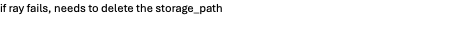

In [ ]:
storage_path = os.path.abspath("./ray_results")

# Initialize Ray with the absolute storage path
ray.init(storage=storage_path)

search_space = {
    "n_hidden": tune.choice([92, 128, 192]),
    "n_latent": tune.choice([10, 20, 30]),
    "n_layers": tune.choice([1,3]),
    "lr": tune.loguniform(1e-4, 1e-2),
    "gene_likelihood": tune.choice(["nb", "zinb"])
}

# Specify a storage path (e.g., a local directory for Ray's outputs)
#run_config = RunConfig(storage_path="./ray_results")

# Run the tuner with the updated configuration
results = tuner.fit(
    andata_bc,
    metric="validation_loss",
    resources={'gpu': 3},  # specify GPU resources
    search_space=search_space,
    num_samples=100,
    max_epochs=1,
    
)
ray.shutdown()

2024-11-13 17:40:28,650	INFO worker.py:1819 -- Started a local Ray instance.


In [ ]:
storage_path = os.path.abspath("./ray_results")

# Initialize Ray with the absolute storage path
ray.init(storage=storage_path)

search_space = {
    "n_hidden": tune.choice([92, 128, 192, 256]),
    "n_latent": tune.choice([10, 20, 30, 40, 50, 60]),
    "n_layers": tune.choice([1, 2, 3]),
    "lr": tune.loguniform(1e-4, 1e-2),
    "gene_likelihood": tune.choice(["nb", "zinb"])
}

# Specify a storage path (e.g., a local directory for Ray's outputs)
#run_config = RunConfig(storage_path="./ray_results")

# Run the tuner with the updated configuration
results = tuner.fit(
    andata_bc,
    metric="validation_loss",
    resources={'gpu': 3},  # specify GPU resources
    search_space=search_space,
    num_samples=100,
    max_epochs=20,
    
)
ray.shutdown()

2024-11-13 13:41:09,964	INFO worker.py:1819 -- Started a local Ray instance.
